In [ ]:
from pylab import *
%matplotlib inline

In [ ]:
caffe_root = '../'
import sys
sys.path.insert(0, caffe_root+'python')
import caffe

In [ ]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb, transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
with open('mnist/lenet_auto_test.prototext', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))
    

In [ ]:
caffe.set_mode_cpu()
solver = None
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [7]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64L, 1L, 28L, 28L)),
 ('label', (64L,)),
 ('conv1', (64L, 20L, 24L, 24L)),
 ('pool1', (64L, 20L, 12L, 12L)),
 ('conv2', (64L, 50L, 8L, 8L)),
 ('pool2', (64L, 50L, 4L, 4L)),
 ('fc1', (64L, 500L)),
 ('score', (64L, 10L)),
 ('loss', ())]

In [8]:
[(k, v[0].data.shape) for k, v in solver.net.params.items()] 

[('conv1', (20L, 1L, 5L, 5L)),
 ('conv2', (50L, 20L, 5L, 5L)),
 ('fc1', (500L, 800L)),
 ('score', (10L, 500L))]

In [9]:
solver.net.forward()
solver.test_nets[0].forward()

{'loss': array(2.358898639678955, dtype=float32)}

 train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


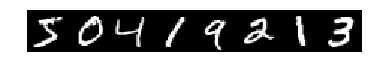

In [13]:
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]
(8L, 28L, 28L)


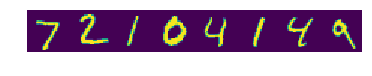

In [26]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28)); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]
print solver.test_nets[0].blobs['data'].data[:8,0].shape

In [27]:
solver.step(1)

In [44]:
#imshow(solver.net.params['conv1'][0].diff[:,0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')
#print solver.net.params['conv1'][0].diff[:, 0].shape
#print solver.test_nets[0].blobs['score'].data.sarhape(1)
#print sum(solver.test_nets[0].blobs['score'].data.argmax(1) == solver.test_nets[0].blobs['label'].data)
print 25 // 25

1


In [46]:
%%time
niter = 200
test_interval = 25
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

for it in range(niter):
    solver.step(1)
    
    train_loss[it] = solver.net.blobs['loss'].data
    
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1) 
                           == solver.test_nets[0].blobs['label'].data)
            
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
Wall time: 1min 5s


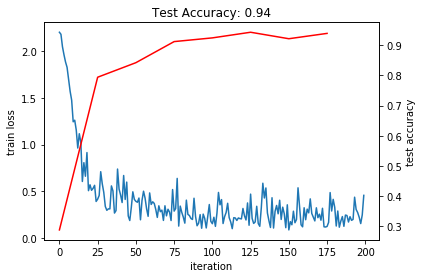

In [47]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

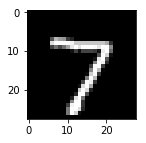

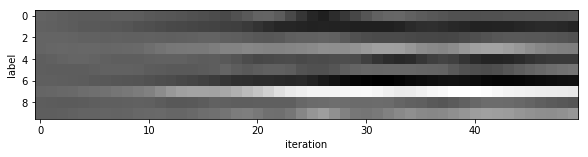

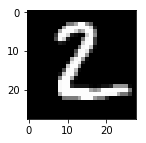

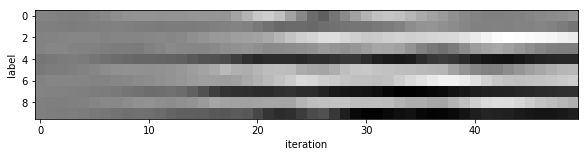

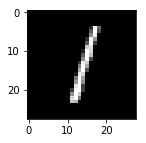

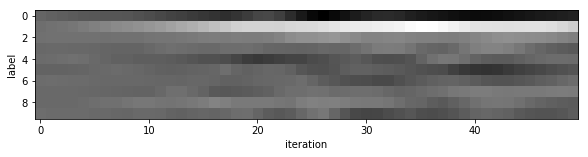

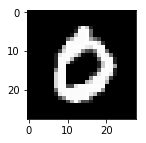

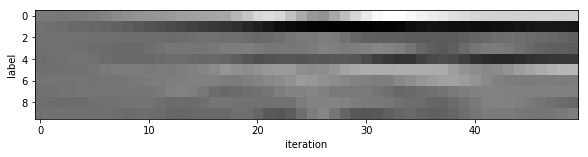

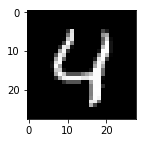

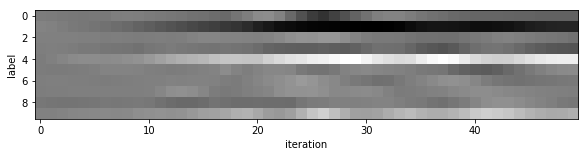

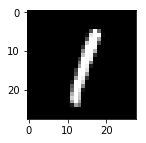

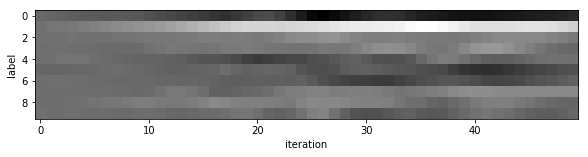

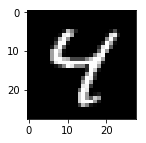

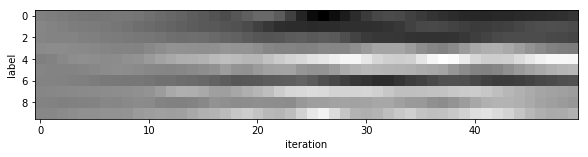

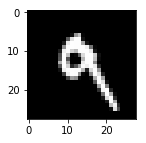

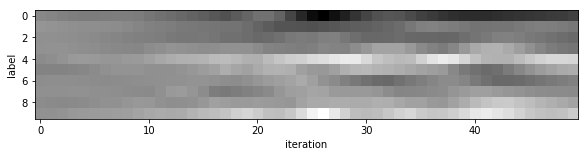

In [48]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

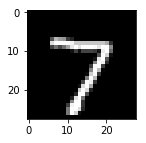

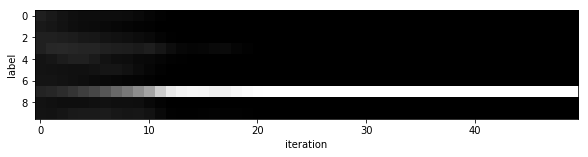

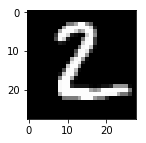

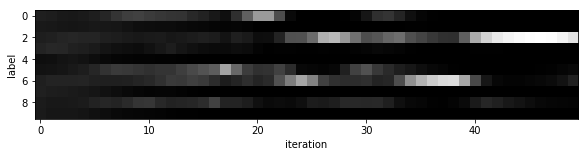

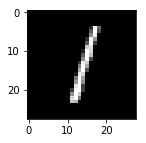

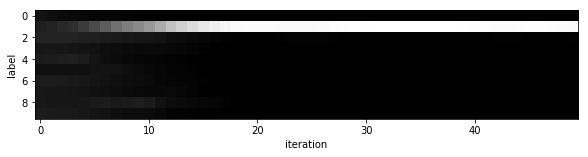

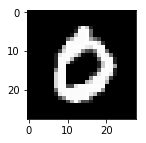

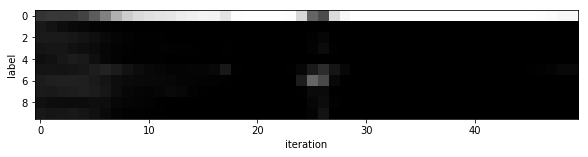

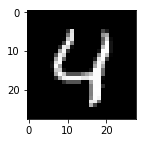

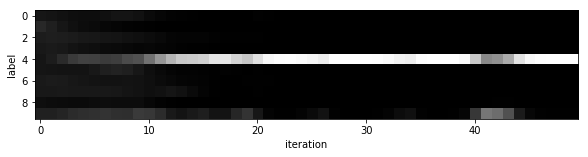

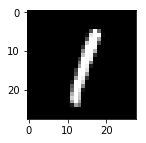

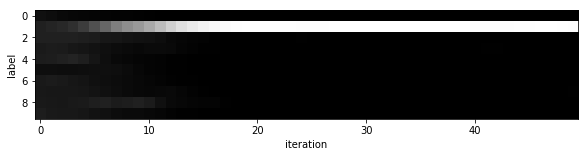

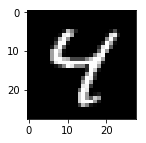

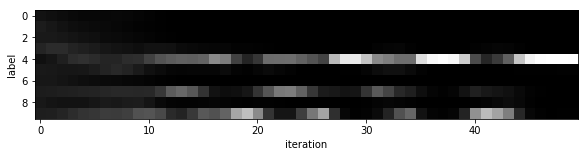

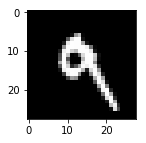

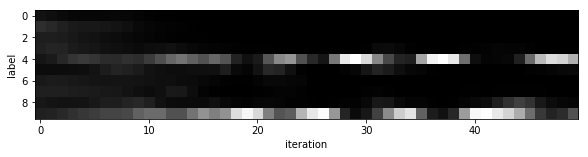

In [49]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

In [ ]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

def custom_net(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb, transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=20, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    
    n.score = L.InnerProduct(n.conv1, num_output=10, weight_filler=dict(type='xavier'))
    
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))
    
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

s.random_seed = 0xCAFFE

s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500
s.test_iter.append(100)
s.max_iter = 10000

s.type = "SGD" # "Adam", "Nesterov"
s.base_lr = 0.01
s.momentum = 0.9
s.weight_decay = 5e-4

s.lr_policy = 'inv' # 'fixed'
s.gamma = 0.0001
s.power = 0.75

s.display = 1000

s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

s.solver_mode = caffe_pb2.SolverParameter.CPU

with open(solver_config_path, 'w') as f:
    f.write(str(s))
    
solver = None
solver = caffe.get_solver(solver_config_path)

niter = 250
test_interval = niter / 10
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
#lr = zeros(niter)

for it in range(niter):
    solver.step(1)
    train_loss[it] = solver.net.blobs['loss'].data
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
            test_acc[it // test_interval] = correct / 1e4
        
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))
